### Import and Load model

In [1]:
import time
import sys
sys.path.append("../")
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np 

import torch
from torch import nn
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from sklearn.metrics import roc_auc_score, brier_score_loss
from sklearn import metrics
from torchmetrics.classification import BinaryCalibrationError

from utils.plots import plot_pr,plot_roc
from utils.metircs import accuracy,mutual_info,nll, ece
from utils.visual import ProgressMeter, AverageMeter, Summary
from data_utils.get_datasets import get_dataset
from model_utils.get_models import get_model
from uncertainty.mc_dropout import mc_dropout_predict
from uncertainty.test_time_aug import test_time_aug_predict
from uncertainty.deep_ensemble import deep_ensembel_predict,EnsembleModel
from uncertainty.baseline_softmax import baseline_softmax_predict

In [2]:
device = torch.device('cuda:0')
model = get_model("vgg16", False, 10)
model = model.to(device)
model.eval()
model.classifier[5].training = True  # 打开dropout
checkpoint = torch.load("/share/home/shiqing/YYM/saved_models/vgg16/2023_11_14_15_54_52/vgg16_best_model_92.13999938964844.pth")
model.load_state_dict(checkpoint['state_dict'])

call torchvision.models
=> create model 'vgg16'


<All keys matched successfully>

In [3]:
#random Gaussian noise fed into an image classifier gives a “prediction confidence” or predicted class probability of 91%
noise = torch.randn(64,3,32,32).to(device)
prob = torch.softmax(model(noise), axis=1)
print(torch.max(prob,axis=1))

torch.return_types.max(
values=tensor([0.6800, 0.8118, 0.5979, 0.7809, 0.4579, 0.5573, 0.3586, 0.4583, 0.4207,
        0.4168, 0.6841, 0.5056, 0.5477, 0.4370, 0.8826, 0.8459, 0.3831, 0.5293,
        0.4665, 0.5660, 0.5370, 0.5751, 0.4215, 0.3774, 0.7997, 0.7439, 0.4541,
        0.4411, 0.9711, 0.5812, 0.3542, 0.3585, 0.4985, 0.5420, 0.6781, 0.4658,
        0.8719, 0.6705, 0.3557, 0.3955, 0.8478, 0.5720, 0.6378, 0.7457, 0.6166,
        0.5090, 0.7384, 0.7673, 0.4273, 0.6497, 0.4651, 0.8933, 0.4887, 0.4820,
        0.7320, 0.8201, 0.4659, 0.8342, 0.4393, 0.5665, 0.6007, 0.5529, 0.6726,
        0.4081], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([4, 6, 6, 6, 4, 2, 4, 6, 4, 4, 6, 2, 2, 6, 6, 6, 4, 6, 2, 2, 4, 6, 2, 4,
        6, 6, 4, 2, 6, 6, 6, 4, 4, 2, 2, 6, 6, 6, 6, 6, 6, 2, 6, 6, 6, 4, 6, 6,
        6, 6, 2, 6, 6, 4, 6, 6, 2, 4, 6, 2, 2, 2, 4, 4], device='cuda:0'))


### Baseline softmax

In [4]:
%reload_ext autoreload
%autoreload 2

In [5]:
datanames = [ "cifar10", "mnist","fashionmnist","svhn","imagenet"]
maxp_list = []
for dataname in datanames:
    val_transform = transforms.Compose(
        [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize(
                (0.4914, 0.4822, 0.4465),
                (0.2023, 0.1994, 0.2010))
        ]
    )
    if dataname=="mnist" or dataname=="fashionmnist":
        val_transform.transforms.insert(2,transforms.Lambda(lambda x:x.repeat(3,1,1)))
    _, val_dataset = get_dataset(dataname,"../data",None,val_transform)
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=128, shuffle=False,
        num_workers=4, pin_memory=True)
    
    probs = baseline_softmax_predict(val_loader, model, device)
    max_prob = torch.max(probs,axis=1)[0].cpu().numpy()
    maxp_list.append(max_prob)

 * Time 0.002 Acc@1 91.990 Acc@5 99.690
 * Time 0.002 Acc@1 8.330 Acc@5 42.810
 * Time 0.002 Acc@1 10.200 Acc@5 40.700
Using downloaded and verified file: ../data/train_32x32.mat
Using downloaded and verified file: ../data/test_32x32.mat
 * Time 0.002 Acc@1 11.282 Acc@5 51.560
 * Time 0.002 Acc@1 0.056 Acc@5 0.470


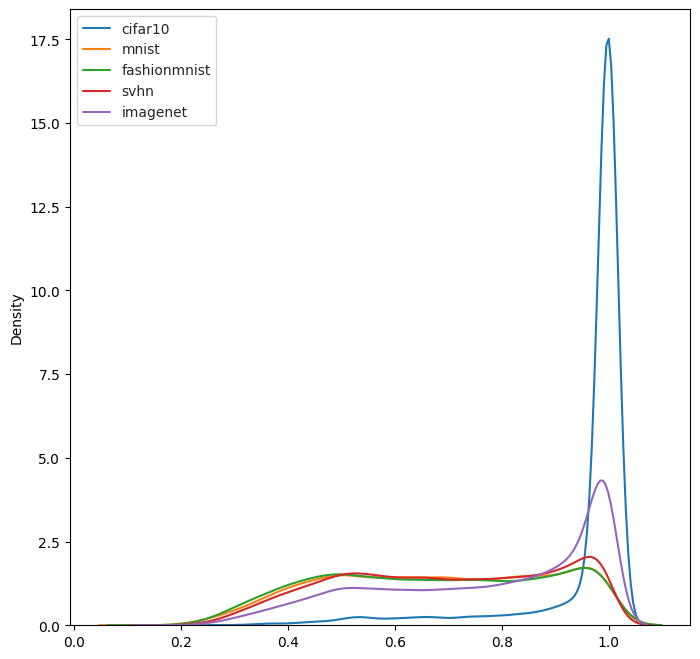

In [6]:
fig, axes = plt.subplots(1,1, figsize=(8, 8))
sns.set_style("whitegrid")
for i , data in  enumerate(maxp_list):
    sns.kdeplot(
        data,
        ax=axes,
        label=datanames[i],
    )

plt.legend()
plt.show()

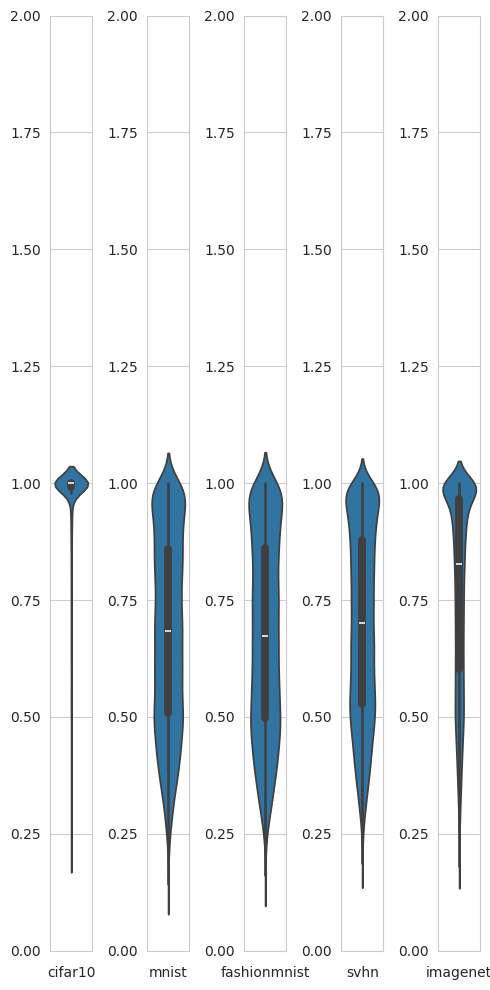

In [7]:
fig, axes = plt.subplots(1,5, figsize=(5, 10))
sns.set_style("white")
for i , mi in enumerate(maxp_list):
    axes[i].set_ylim(0,2)
    axes[i].set_xlabel(datanames[i])
    sns.violinplot(
        mi,
        ax=axes[i],
    )

plt.tight_layout()
plt.show()

In [8]:
#IND样本视为正样本， mnist样本视为负样本
y_true = [1]*len(maxp_list[0])+[0]*len(maxp_list[1])
y_score = np.concatenate([maxp_list[0],maxp_list[1]])

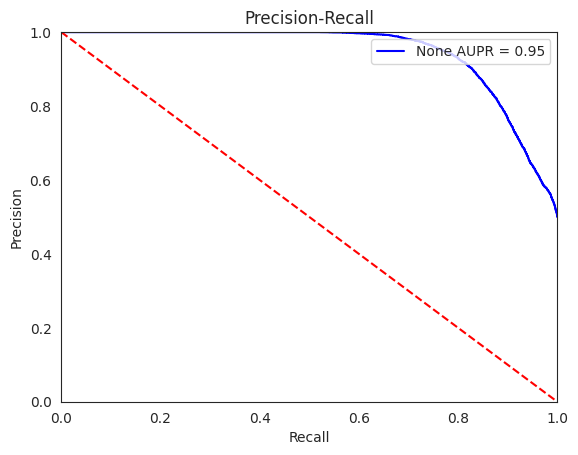

In [9]:
plot_pr(y_true,y_score)

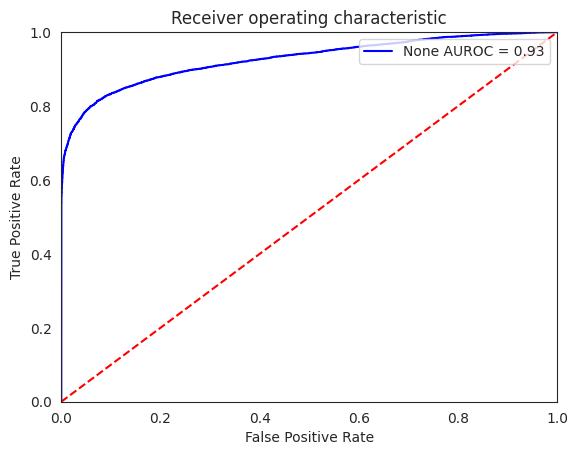

In [10]:
plot_roc(y_true,y_score,)

In [11]:
#IND样本视为负样本， mnist样本视为正样本
y_true = [0]*len(maxp_list[0])+[1]*len(maxp_list[1])
y_score = np.concatenate([maxp_list[0],maxp_list[1]])*-1

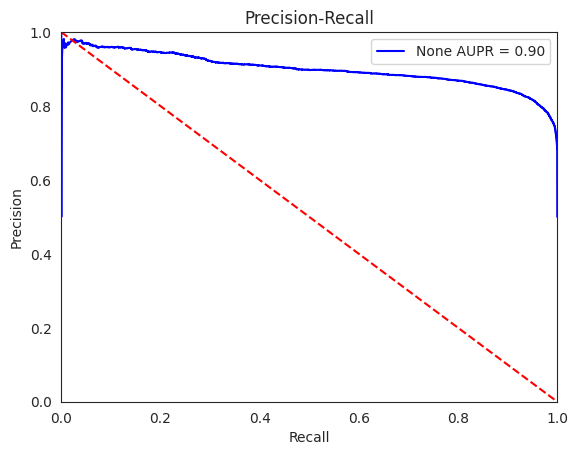

In [12]:
plot_pr(y_true,y_score)

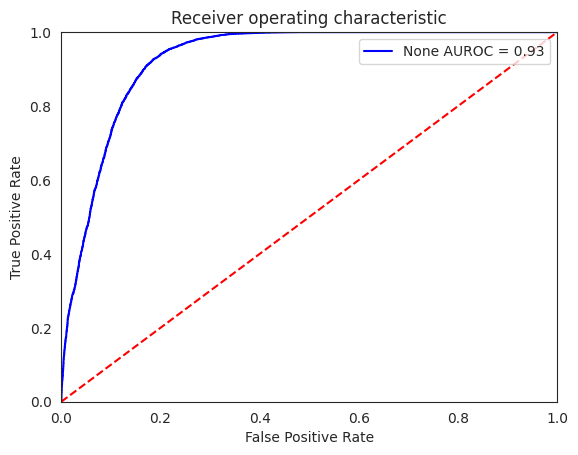

In [13]:
plot_roc(y_true,y_score,)

In [14]:
ece_score = ece(y_score,np.array(y_true))
print(f"CALIBRATION ERROR:{ece_score}")

CALIBRATION ERROR:0.1920885145664215


In [15]:
y_true = [1]*len(maxp_list[0])+[0]*len(maxp_list[1])
y_score = np.concatenate([maxp_list[0],maxp_list[1]])
brier_score = brier_score_loss(y_true, y_score)

In [16]:
nll_score = nll(y_score, np.array(y_true))
print(nll_score)

0.8041119024067369


### MC Dropout

In [17]:
datanames = ["cifar10","mnist", "fashionmnist","svhn","imagenet"]
mi_list = []
for dataname in datanames:
    val_transform = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize(
                (0.4914, 0.4822, 0.4465),
                (0.2023, 0.1994, 0.2010))
    ]
    )
    if dataname=="mnist" or dataname=="fashionmnist":
        val_transform.transforms.insert(2,transforms.Lambda(lambda x:x.repeat(3,1,1)))
    _, val_dataset = get_dataset(dataname,"../data",None,val_transform)
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=128, shuffle=False,
        num_workers=4, pin_memory=True)

    test_time_aug_predict(val_loader, model, device)
    mi = mutual_info(probs.cpu().numpy())
    mi_list.append(mi)

 * Time 0.060 Acc@1 90.910


AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
fig, axes = plt.subplots(1,1, figsize=(8, 8))
sns.set_style("whitegrid")
for i , data in  enumerate(mi_list):
    sns.kdeplot(
        data,
        ax=axes,
        label=datanames[i],
    )

plt.legend()
plt.show()

In [ ]:
fig, axes = plt.subplots(1,5, figsize=(5, 10))
sns.set_style("white")
for i , mi in enumerate(mi_list):
    axes[i].set_ylim(0,0.06)
    axes[i].set_xlabel(datanames[i])
    sns.violinplot(
        mi,
        ax=axes[i],
    )

plt.tight_layout()
plt.show()

In [ ]:
##IND样本视为正样本， mnist样本视为负样本
y_true = [1]*len(mi_list[0])+[0]*len(mi_list[1])
y_score = np.concatenate([mi_list[0],mi_list[1]])

In [ ]:
plot_pr(y_true,y_score)

In [ ]:
plot_roc(y_true,y_score)

In [ ]:
##IND样本视为负样本， mnist样本视为正样本
y_true = [0]*len(mi_list[0])+[1]*len(mi_list[1])
y_score = np.concatenate([mi_list[0],mi_list[1]]) * -1

In [ ]:
plot_pr(y_true,y_score)

In [ ]:
plot_roc(y_true,y_score)

In [ ]:
ece =  BinaryCalibrationError(n_bins=2, norm='l2')(torch.Tensor(y_score),torch.Tensor(y_true))
print(f"CALIBRATION ERROR:{ece}")

## Test time augmentation

In [ ]:
datanames = ["cifar10","mnist", "fashionmnist","svhn","imagenet"]
mi_list = []
for dataname in datanames:
    val_transform = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize(
                (0.4914, 0.4822, 0.4465),
                (0.2023, 0.1994, 0.2010))
    ]
    )
    if dataname=="mnist" or dataname=="fashionmnist":
        val_transform.transforms.insert(2,transforms.Lambda(lambda x:x.repeat(3,1,1)))
    _, val_dataset = get_dataset(dataname,"../data",None,val_transform)
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=128, shuffle=False,
        num_workers=4, pin_memory=True)

    probs = mc_dropout_predict(val_loader, model, device, 8)
    mi = mutual_info(probs.cpu().numpy())
    mi_list.append(mi)

In [ ]:
fig, axes = plt.subplots(1,1, figsize=(8, 8))
sns.set_style("whitegrid")
for i , data in  enumerate(mi_list):
    sns.kdeplot(
        data,
        ax=axes,
        label=datanames[i],
    )

plt.legend()
plt.show()

In [ ]:
fig, axes = plt.subplots(1,5, figsize=(5, 10))
sns.set_style("white")
for i , mi in enumerate(mi_list):
    axes[i].set_ylim(0,0.06)
    axes[i].set_xlabel(datanames[i])
    sns.violinplot(
        mi,
        ax=axes[i],
    )

plt.tight_layout()
plt.show()

In [ ]:
##IND样本视为正样本， mnist样本视为负样本
y_true = [0]*len(mi_list[0])+[1]*len(mi_list[1])
y_score = np.concatenate([mi_list[0],mi_list[1]])

In [ ]:
plot_pr(y_true,y_score)

In [ ]:
plot_roc(y_true,y_score)

In [ ]:
##IND样本视为负样本， mnist样本视为正样本
y_true = [1]*len(mi_list[0])+[0]*len(mi_list[1])
y_score = np.concatenate([mi_list[0],mi_list[1]]) * -1

In [ ]:
plot_pr(y_true,y_score)

In [ ]:
plot_roc(y_true,y_score)

In [ ]:
ece =  BinaryCalibrationError(n_bins=2, norm='l2')(torch.Tensor(y_score),torch.Tensor(y_true))
print(f"CALIBRATION ERROR:{ece}")

## deep Ensembles

In [ ]:
datanames = ["cifar10","mnist", "fashionmnist","svhn","imagenet"]
mi_list = []
models_path = ["../saved_models/vgg16/2023_11_15_16_36_44/vgg16_best_model_91.78.pth",
               "../saved_models/vgg16/2023_11_15_21_15_51/vgg16_best_model_92.90.pth",
               "../saved_models/vgg16/2023_11_16_14_10_39/vgg16_best_model_92.90.pth"]

vgg_ensemble = EnsembleModel("vgg16", models_path, device)
for dataname in datanames:
    val_transform = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize(
                (0.4914, 0.4822, 0.4465),
                (0.2023, 0.1994, 0.2010))
    ]
    )
    if dataname=="mnist" or dataname=="fashionmnist":
        val_transform.transforms.insert(2,transforms.Lambda(lambda x:x.repeat(3,1,1)))
    _, val_dataset = get_dataset(dataname,"../data",None,val_transform)
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=128, shuffle=False,
        num_workers=4, pin_memory=True)

    probs = deep_ensembel_predict(val_loader, vgg_ensemble,  device)
    mi = mutual_info(probs.cpu().numpy())
    mi_list.append(mi)

In [ ]:
fig, axes = plt.subplots(1,1, figsize=(8, 8))
sns.set_style("whitegrid")
for i , data in  enumerate(mi_list):
    sns.kdeplot(
        data,
        ax=axes,
        label=datanames[i],
    )

plt.legend()
plt.show()

In [ ]:
fig, axes = plt.subplots(1,5, figsize=(5, 10))
sns.set_style("white")
for i , mi in enumerate(mi_list):
    axes[i].set_ylim(0,0.06)
    axes[i].set_xlabel(datanames[i])
    sns.violinplot(
        mi,
        ax=axes[i],
    )

plt.tight_layout()
plt.show()

In [ ]:
##IND样本视为正样本， mnist样本视为负样本
y_true = [0]*len(mi_list[0])+[1]*len(mi_list[1])
y_score = np.concatenate([mi_list[0],mi_list[1]])

In [ ]:
plot_pr(y_true,y_score)

In [ ]:
plot_roc(y_true,y_score)

In [ ]:
##IND样本视为负样本， mnist样本视为正样本
y_true = [1]*len(mi_list[0])+[0]*len(mi_list[1])
y_score = np.concatenate([mi_list[0],mi_list[1]]) * -1

In [ ]:
plot_pr(y_true,y_score)

In [ ]:
plot_roc(y_true,y_score)

In [ ]:
ece =  BinaryCalibrationError(n_bins=2, norm='l2')(torch.Tensor(y_score),torch.Tensor(y_true))
print(f"CALIBRATION ERROR:{ece}")

## Bayesian Neural Network(SVI)